# **IMPORTS AND METHODS**

In [0]:
#pip install similaritymeasures

In [0]:
#pip install dtaidistance

In [0]:
import pywt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
#from dtaidistance import dtw
#import similaritymeasures

In [0]:
def euclidianDistance(X,Y):
   return np.linalg.norm(X.values-Y.values)

In [0]:
#def FrechetDistance(X,Y):
#  return similaritymeasures.frechet_dist(X,Y)

In [0]:
#def DtwDistance(X,Y):
#  return dtw.distance(X,Y)

In [0]:
def similaritySearch(query_timeseries,query_timeseries_summarized,all_timeseries,all_timeseries_summarized,distanceMethod):
  
  Dclosest = np.Infinity
  mostSimilarTimeSeriesRow = -1
  skippedQueries = 0
  
  for i in range(0,all_timeseries.shape[1]-1):
    Dsummarization = distanceMethod(all_timeseries_summarized[i],query_timeseries_summarized)
    if ( Dsummarization <= Dclosest):
      Doriginal = distanceMethod(all_timeseries[i],query_timeseries)
      if ( Doriginal < Dclosest):
        Dclosest = Doriginal
        mostSimilarTimeSeriesRow = i
    else:
     skippedQueries = skippedQueries + 1
  
  mostSimilarTimeSeries = all_timeseries[mostSimilarTimeSeriesRow] if mostSimilarTimeSeriesRow > -1 else None
  return { 'mostSimilarTimeSeriesRow' : mostSimilarTimeSeriesRow, 'mostSimilarTimeSeries' : mostSimilarTimeSeries, 'Dclosest' : Dclosest , 'skippedQueries' : skippedQueries }

In [0]:
def similaritySearchWithoutSummarization(query_timeseries,all_timeseries,distanceMethod):
  Dclosest = np.Infinity
  mostSimilarTimeSeriesRow = -1
  skippedQueries = 0
  for i in range(0,all_timeseries.shape[1]-1):
      Doriginal = distanceMethod(all_timeseries[i],query_timeseries)
      if ( Doriginal < Dclosest):
        Dclosest = Doriginal
        mostSimilarTimeSeriesRow = i
  mostSimilarTimeSeries = all_timeseries[mostSimilarTimeSeriesRow] if mostSimilarTimeSeriesRow > -1 else None
  return { 'mostSimilarTimeSeriesRow' : mostSimilarTimeSeriesRow, 'mostSimilarTimeSeries' : mostSimilarTimeSeries, 'Dclosest' : Dclosest , 'skippedQueries' : skippedQueries }


In [0]:
def AllQueryTimeSeriesSimilarities(all_query_timeseries,all_query_timeseries_summarized,all_timeseries,all_timeseries_summarized,distanceMethod,Search = 'original'):
  queriesAndSimilarity = []
  queryCount = all_query_timeseries.shape[1]
  for i in range(0,queryCount):
    if i%10==0:
      print("{} queries left".format(queryCount-i))
    if Search == 'summarized' :
     result = similaritySearch(all_query_timeseries[i],all_query_timeseries_summarized[i],all_timeseries,all_timeseries_summarized,distanceMethod)
    else:
     result = similaritySearchWithoutSummarization(all_query_timeseries[i],all_timeseries,distanceMethod)
    queriesAndSimilarity.append({'query_id' : i , 'most_similar_timeseries' : result['mostSimilarTimeSeriesRow'] , 'Dclosest' : result['Dclosest'] , 'skippedQueries' : result['skippedQueries']})
  
  return queriesAndSimilarity

In [0]:
def read_series(filename,vers):
  """
  on va lire le fichier soit de coeff ou de data on aura besoin de la vers
  256 fichier de base (1024byte)
  32 fichier reduit a 128 byte
  16 fichier reduit a 64 bytes
  8 fichier reduit a 32 byte
  """
  
  time_series = np.fromfile(filename, dtype=np.float32).reshape(-1, vers)
  t=time_series.transpose()
  df= pd.DataFrame(t)
  print("file {0} has the shape of {1}".format(filename.split("/")[-1],df.shape))
  return df

In [0]:
def SimilarityWithSummarizationSafetyRate(df1,df2):
  count = 0
  df1Column = df1.loc[: ,'most_similar_timeseries']
  df2Column = df2.loc[: ,'most_similar_timeseries']
  for i in range(0,df1Column.size):
    if df1Column[i] == df2Column[i]:
      continue
    else:
      count = count + 1
  safety = df1Column.size - count
  return safety * 100 / df1Column.size

# **SIESMIC DATA**

In [0]:
# siesmic imeseries dataset
df_reduced_seismic_data_128=read_series("/content/drive/My Drive/Colab Notebooks/data science/reduced_siesmic/red_seismic_50k_128.bin",32)
df_reduced_seismic_data_64=read_series("/content/drive/My Drive/Colab Notebooks/data science/reduced_siesmic/red_seismic_50k_64.bin",16)
df_reduced_seismic_data_32=read_series("/content/drive/My Drive/Colab Notebooks/data science/reduced_siesmic/red_seismic_50k_32.bin",8)
df_original_seismic_data=read_series("/content/drive/My Drive/Colab Notebooks/data science/reduced_siesmic/seismic_size50k_len256_znorm.bin",256)

# siesmic query timeseries
df_reduced_seismic_query_len256 = read_series("/content/drive/My Drive/Colab Notebooks/data science/reduced_siesmic_query/seismic-query_size100_len256_znorm.bin",256)
df_reduced_seismic_query_len128 = read_series("/content/drive/My Drive/Colab Notebooks/data science/reduced_siesmic_query/red_seismic_size100_128.bin",32)
df_reduced_seismic_query_len64 = read_series("/content/drive/My Drive/Colab Notebooks/data science/reduced_siesmic_query/red_seismic_size100_64.bin",16)
df_reduced_seismic_query_len32 = read_series("/content/drive/My Drive/Colab Notebooks/data science/reduced_siesmic_query/red_seismic_size100_32.bin",8)


file red_seismic_50k_128.bin has the shape of (32, 50000)
file red_seismic_50k_64.bin has the shape of (16, 50000)
file red_seismic_50k_32.bin has the shape of (8, 50000)
file seismic_size50k_len256_znorm.bin has the shape of (256, 50000)
file seismic-query_size100_len256_znorm.bin has the shape of (256, 100)
file red_seismic_size100_128.bin has the shape of (32, 100)
file red_seismic_size100_64.bin has the shape of (16, 100)
file red_seismic_size100_32.bin has the shape of (8, 100)


In [0]:
result = AllQueryTimeSeriesSimilarities(df_reduced_seismic_query_len256,df_reduced_seismic_query_len64,df_original_seismic_data,df_reduced_seismic_data_64,euclidianDistance,'summarized')
r = pd.DataFrame(result)
result = AllQueryTimeSeriesSimilarities(df_reduced_seismic_query_len256,df_reduced_seismic_query_len64,df_original_seismic_data,df_reduced_seismic_data_64,euclidianDistance)
s = pd.DataFrame(result)

In [0]:
random_series = np.random.randint(0,99)
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('timeseries query {} with the most similar timeseries using summarization'.format(random_series))
ax1.plot(df_reduced_seismic_query_len256[random_series],'m')
ax2.plot(df_original_seismic_data[r.loc[random_series]['most_similar_timeseries']])
plt.show()
fig2, (ax3, ax4) = plt.subplots(2)
fig2.suptitle('timeseries query {} with the most similar timeseries without summarization'.format(random_series))
ax3.plot(df_reduced_seismic_query_len256[random_series],'m')
ax4.plot(df_original_seismic_data[s.loc[random_series]['most_similar_timeseries']])
plt.show()
print("pruning risk is {}%".format(100 - SimilarityWithSummarizationSafetyRate(r,s)))
mean_skipped = r['skippedQueries'].mean()
print("the ratio of pruned to whole {}".format(mean_skipped / 50000))

# **SYNTHETIC DATA**

In [0]:
# synthetic series dataset
df_reduced_synthetic_data_128=read_series("/content/drive/My Drive/Colab Notebooks/data science/reduced_synthetic/red_synthetic_50k_128.bin",32)
df_reduced_synthetic_data_64=read_series("/content/drive/My Drive/Colab Notebooks/data science/reduced_synthetic/red_synthetic_50k_64.bin",16)
df_reduced_synthetic_data_32=read_series("/content/drive/My Drive/Colab Notebooks/data science/reduced_synthetic/red_synthetic_50k_32.bin",8)
df_original_synthetic_data=read_series("/content/drive/My Drive/Colab Notebooks/data science/reduced_synthetic/synthetic_size50k_len256_znorm.bin",256)

# synthetic query timeseries
df_reduced_synthetic_query_len256 = read_series("/content/drive/My Drive/Colab Notebooks/data science/reduced_synthetic_query/synthetic-query_size100_len256_znorm.bin",256)
df_reduced_synthetic_query_len128 = read_series("/content/drive/My Drive/Colab Notebooks/data science/reduced_synthetic_query/red_synthetic_size100_128.bin",32)
df_reduced_synthetic_query_len64 = read_series("/content/drive/My Drive/Colab Notebooks/data science/reduced_synthetic_query/red_synthetic_size100_64.bin",16)
df_reduced_synthetic_query_len32 = read_series("/content/drive/My Drive/Colab Notebooks/data science/reduced_synthetic_query/red_synthetic_size100_32.bin",8)


file red_synthetic_50k_128.bin has the shape of (32, 50000)
file red_synthetic_50k_64.bin has the shape of (16, 50000)
file red_synthetic_50k_32.bin has the shape of (8, 50000)
file synthetic_size50k_len256_znorm.bin has the shape of (256, 50000)
file synthetic-query_size100_len256_znorm.bin has the shape of (256, 100)
file red_synthetic_size100_128.bin has the shape of (32, 100)
file red_synthetic_size100_64.bin has the shape of (16, 100)
file red_synthetic_size100_32.bin has the shape of (8, 100)


# **128 BITS**

In [0]:
result = AllQueryTimeSeriesSimilarities(df_reduced_synthetic_query_len256,df_reduced_synthetic_query_len128,df_original_synthetic_data,df_reduced_synthetic_data_128,euclidianDistance,'summarized')
s2 = pd.DataFrame(result)

100 queries left
90 queries left
80 queries left
70 queries left
60 queries left
50 queries left
40 queries left
30 queries left
20 queries left
10 queries left


In [0]:
result2 = AllQueryTimeSeriesSimilarities(df_reduced_synthetic_query_len256,df_reduced_synthetic_query_len128,df_original_synthetic_data,df_reduced_synthetic_data_128,euclidianDistance)
r2 = pd.DataFrame(result2)

100 queries left
90 queries left
80 queries left
70 queries left
60 queries left
50 queries left
40 queries left
30 queries left
20 queries left
10 queries left


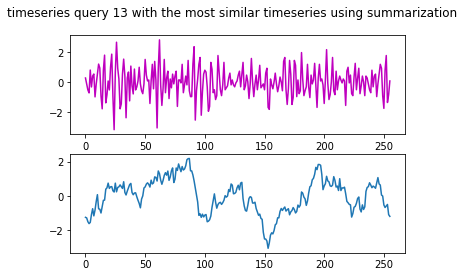

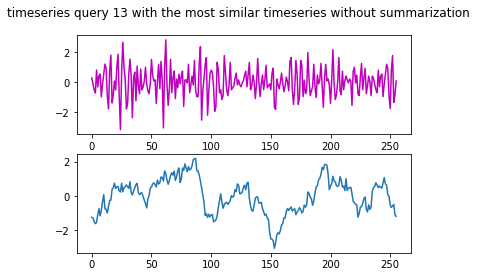

pruning risk using 32 bytes summarization is 0.0%
the ratio of pruned to whole 0.74897


In [0]:
random_series = np.random.randint(0,99)
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('timeseries query {} with the most similar timeseries using summarization'.format(random_series))
ax1.plot(df_reduced_synthetic_query_len256[random_series],'m')
ax2.plot(df_original_synthetic_data[r2.loc[random_series]['most_similar_timeseries']])
plt.show()
fig2, (ax3, ax4) = plt.subplots(2)
fig2.suptitle('timeseries query {} with the most similar timeseries without summarization'.format(random_series))
ax3.plot(df_reduced_synthetic_query_len256[random_series],'m')
ax4.plot(df_original_synthetic_data[s2.loc[random_series]['most_similar_timeseries']])
plt.show()
print("pruning risk using 32 bytes summarization is {}%".format(100 - SimilarityWithSummarizationSafetyRate(r,s)))
mean_skipped = r['skippedQueries'].mean()
print("the ratio of pruned to whole {}".format(mean_skipped / 50000))

# ***64 BITS***

In [0]:
result = AllQueryTimeSeriesSimilarities(df_reduced_synthetic_query_len256,df_reduced_synthetic_query_len64,df_original_synthetic_data,df_reduced_synthetic_data_64,euclidianDistance,'summarized')
s2 = pd.DataFrame(result)
result2 = AllQueryTimeSeriesSimilarities(df_reduced_synthetic_query_len256,df_reduced_synthetic_query_len64,df_original_synthetic_data,df_reduced_synthetic_data_64,euclidianDistance)
r2 = pd.DataFrame(result2)

In [0]:
random_series = np.random.randint(0,99)
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('timeseries query {} with the most similar timeseries using summarization'.format(random_series))
ax1.plot(df_reduced_synthetic_query_len256[random_series],'m')
ax2.plot(df_original_synthetic_data[r2.loc[random_series]['most_similar_timeseries']])
plt.show()
fig2, (ax3, ax4) = plt.subplots(2)
fig2.suptitle('timeseries query {} with the most similar timeseries without summarization'.format(random_series))
ax3.plot(df_reduced_synthetic_query_len256[random_series],'m')
ax4.plot(df_original_synthetic_data[s2.loc[random_series]['most_similar_timeseries']])
plt.show()
print("pruning risk using 16 bytes summarization is {}%".format(100 - SimilarityWithSummarizationSafetyRate(r,s)))
mean_skipped = r['skippedQueries'].mean()
print("the ratio of pruned to whole {}".format(mean_skipped / 50000))

# **32 BITS**

In [0]:
result = AllQueryTimeSeriesSimilarities(df_reduced_synthetic_query_len256,df_reduced_synthetic_query_len32,df_original_synthetic_data,df_reduced_synthetic_data_32,euclidianDistance,'summarized')
s2 = pd.DataFrame(result)
result2 = AllQueryTimeSeriesSimilarities(df_reduced_synthetic_query_len256,df_reduced_synthetic_query_len32,df_original_synthetic_data,df_reduced_synthetic_data_32,euclidianDistance)
r2 = pd.DataFrame(result2)

100 queries left
90 queries left
80 queries left
70 queries left
60 queries left
50 queries left
40 queries left
30 queries left
20 queries left
10 queries left
100 queries left
90 queries left
80 queries left
70 queries left
60 queries left
50 queries left
40 queries left
30 queries left
20 queries left
10 queries left


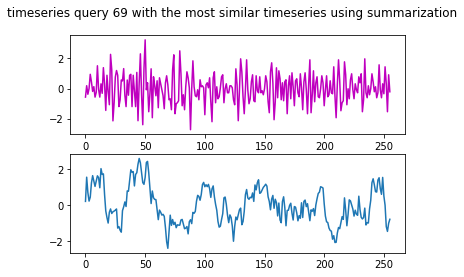

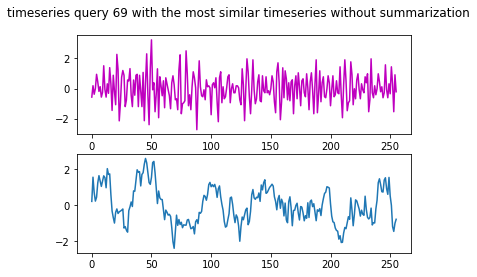

pruning risk using 8 bytes summarization is 0.0%
the ratio of pruned to whole 0.74897
    query_id  most_similar_timeseries   Dclosest  skippedQueries
0          0                     5422  21.599037           22860
1          1                    22976  21.846832           21245
2          2                    39946  21.594009           20553
3          3                    48522  21.261740           22422
4          4                    35497  21.814032           22740
..       ...                      ...        ...             ...
95        95                    14814  21.571630           17677
96        96                      254  21.958548           18747
97        97                    33545  21.741234           22252
98        98                    25042  21.600487           23084
99        99                    22878  21.467922           22225

[100 rows x 4 columns]


In [0]:
random_series = np.random.randint(0,99)
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('timeseries query {} with the most similar timeseries using summarization'.format(random_series))
ax1.plot(df_reduced_synthetic_query_len256[random_series],'m')
ax2.plot(df_original_synthetic_data[r2.loc[random_series]['most_similar_timeseries']])
plt.show()
fig2, (ax3, ax4) = plt.subplots(2)
fig2.suptitle('timeseries query {} with the most similar timeseries without summarization'.format(random_series))
ax3.plot(df_reduced_synthetic_query_len256[random_series],'m')
ax4.plot(df_original_synthetic_data[s2.loc[random_series]['most_similar_timeseries']])
plt.show()
print("pruning risk using 8 bytes summarization is {}%".format(100 - SimilarityWithSummarizationSafetyRate(r,s)))
mean_skipped = r['skippedQueries'].mean()
print("the ratio of pruned to whole {}".format(mean_skipped / 50000))
print(s2)

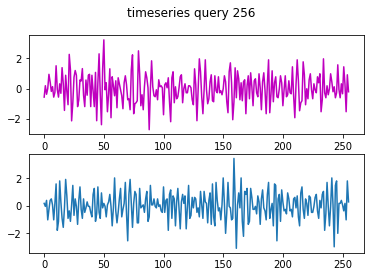

In [0]:
fig, (ax1,ax2) = plt.subplots(2)
fig.suptitle('timeseries query 256')
ax1.plot(df_reduced_synthetic_query_len256[69],'m')
ax2.plot(df_reduced_seismic_query_len256[69])
plt.show()